# Set Up Workspace
Import the libaries need to handle data tables

In [23]:
import pandas as pd # used to handle dataframes/tables
# used to make plots
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
from plotnine import *

set variables to necessary directories and file names

In [24]:
ann_dir="../data/annotations/LFY_Jin_2021/BySummit"
genewise_f="LFY_DexvsMock_genewise_ann.csv"
peakwise_f="LFY_DexvsMock_peakwise_ann.csv"
nomask_dir="noMask_qval10_wiDups"
gsmask_dir="gsMask_qval10_wiDups"
blmask_dir="blMask_qval10_wiDups"

# Compare annotation of  peaks masked by GS vs peaks not masked by GS

First import peakwise files from before and after GS mask

In [25]:
nomask_peakwise_df = pd.read_csv(ann_dir+"/"+nomask_dir + "/" + peakwise_f)
gsmask_peakwise_df = pd.read_csv(ann_dir+"/"+gsmask_dir + "/" + peakwise_f)

In the table containing all peaks before masking add a column who values equal:
* False if the peak is not masked by Greenscreen
* True if the peak is masked by Greenscreen

In [26]:
nomask_peakwise_df["gs_masked_out"] = (
    nomask_peakwise_df.apply(
        lambda x: not x["name"] in gsmask_peakwise_df["name"].values, 
        axis=1))

In [27]:
nomask_peakwise_df.columns

Index(['chr', 'start', 'stop', 'name', 'signal', 'strand', 'roundOfAnnotation',
       'numGenes', 'gene_id', 'gene_overlap', 'distance_from_gene',
       'summit_ann', 'qValue', 'summit', 'TransposableElement:name',
       'TransposableElement:location', 'TransposableElementGene:name',
       'TransposableElementGene:location', 'TransposonFragment:name',
       'TransposonFragment:location', 'Pseudogene:name', 'Pseudogene:location',
       'geneMeta:Name', 'geneMeta:Alias', 'geneMeta:Note',
       'geneMeta:locus_type', 'geneMeta:description',
       'RNA_DE_seed:log2FoldChange', 'RNA_DE_seed:padj',
       'RNA2_DE_callus_t1hr:log2FoldChange', 'RNA2_DE_callus_t1hr:padj',
       'RNA2_DE_callus_t6hr:log2FoldChange', 'RNA2_DE_callus_t6hr:padj',
       'RNA2_DE_callus_t24hr:log2FoldChange', 'RNA2_DE_callus_t24hr:padj',
       'gs_masked_out'],
      dtype='object')

Check the number of peaks that were masked

In [28]:
nomask_peakwise_df["gs_masked_out"].value_counts()

False    1680
True       65
Name: gs_masked_out, dtype: int64

Currently `round of Annotation` is a column with values
* 1 which labels a peak as annotated in round1
* 2 which labels a peak as annotated in round2
* NaN which labels a peak as unannotated
For readability, I want to change these values to the following strings respectively
* round1
* round2
* unannotated

In [29]:
# change round1 and round2 values
roa_strings_dict={1: "round1", 2: "round2"}
nomask_peakwise_df = (
    nomask_peakwise_df
    .replace({"roundOfAnnotation": roa_strings_dict}))
# set the peaks that were not annotated to genes to "unannotated"
nomask_peakwise_df["roundOfAnnotation"] = (
    nomask_peakwise_df["roundOfAnnotation"].fillna("unannotated"))

Create a counts table of the number of peaks that were: 
* not annotated
* annotated in round 1 annotation
* annotated in round 2 annotation

and whether they were masked out by greenscreen or not.

In [30]:
# create a dataframe of necessary info
numPeaksAnnGivMask_df = (pd.DataFrame(nomask_peakwise_df.groupby(
    'roundOfAnnotation')['gs_masked_out']
    .value_counts())
    .rename(columns={'gs_masked_out':'number of peaks'})
    .reset_index())
# set `gs_masked_out` to str type
numPeaksAnnGivMask_df['gs_masked_out'] = (
    numPeaksAnnGivMask_df['gs_masked_out'].astype(str))
# pivot the table so that the column names
# represent the annotation labels and
# the index labels whether the peaks were
# masked out by the greenscreen (True) 
# or not (False)
numPeaksAnnGivMask_pivot_df = (
    numPeaksAnnGivMask_df.pivot(
    index="gs_masked_out",
    columns="roundOfAnnotation",
    values="number of peaks"))
numPeaksAnnGivMask_pivot_df = numPeaksAnnGivMask_pivot_df.fillna(0)
numPeaksAnnGivMask_pivot_df

roundOfAnnotation,round1,round2,unannotated
gs_masked_out,,,
False,1207.0,257.0,216.0
True,8.0,0.0,57.0


Since so few peaks are masked we calculate the percent for each row in the dataframe.

In [31]:
perPeaksAnnGivMask_pivot_df = numPeaksAnnGivMask_pivot_df.apply(lambda x: x/x.sum(),axis=1)
perPeaksAnnGivMask_pivot_df

roundOfAnnotation,round1,round2,unannotated
gs_masked_out,,,
False,0.718452,0.152976,0.128571
True,0.123077,0.000000,0.876923


Before plotting this table to a stacked bar graph, we prepare the dataframe.

In [32]:
perPeaksAnnGivMask_pivot_V2_df = perPeaksAnnGivMask_pivot_df.loc[['True','False'],:]
perPeaksAnnGivMask_sorted_pivot_df = (
    perPeaksAnnGivMask_pivot_df
    .reset_index()
    .rename_axis(None,axis=1))
perPeaksAnnGivMask_sorted_pivot_df
perPeaksAnnGivMask_sorted_pivot_V2_df = (
    perPeaksAnnGivMask_pivot_V2_df
    .reset_index()
    .rename_axis(None,axis=1))
perPeaksAnnGivMask_sorted_pivot_df

,gs_masked_out,round1,round2,unannotated
0,False,0.718452,0.152976,0.128571
1,True,0.123077,0.000000,0.876923


Use matplotlib libary to plot the stacked bargraph to display the data

Text(0.5, 1.0, 'Greenscreen Masked Peaks Annotation')

<Figure size 1008x1008 with 0 Axes>

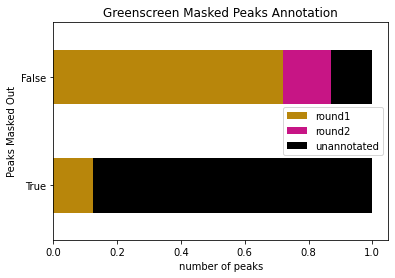

In [33]:
# set the figure size
plt.figure(figsize=(14, 14))

color_dict= (
    {"round1":'o',
    "round2":'b',
    "unannotated":'k'})

# from raw value to percentage
ax = perPeaksAnnGivMask_sorted_pivot_V2_df.plot(
    color=['darkgoldenrod','mediumvioletred','k'],
    x="gs_masked_out",
    kind='barh',
    stacked=True,
    mark_right=True)

ax.set_xlabel("number of peaks")
ax.set_ylabel("Peaks Masked Out")
plt.title("Greenscreen Masked Peaks Annotation")

In [34]:
perPeaksAnnGivMask_sorted_pivot_df

,gs_masked_out,round1,round2,unannotated
0,False,0.718452,0.152976,0.128571
1,True,0.123077,0.000000,0.876923


# Include Differential Expressed Gene Information to Barchart
First organize the columns which contain the p-values of the genes annotated to the peaks. Note that if multiple genes are annotated to a single peak then we only care about the gene that is differentially expressed with the most significant p-value.

In [35]:
def return_min_pval(foo):
    #print(foo)
    foo_arr=str(foo).split(";")
    min_val=1
    for val in foo_arr:
        if val != "nan":
            if float(val)<min_val:
                min_val = float(val)
    return(min_val)

In [36]:
de_padj_cols=["RNA_DE_seed:padj", 
              "RNA2_DE_callus_t1hr:padj", 
              "RNA2_DE_callus_t6hr:padj",
              "RNA2_DE_callus_t24hr:padj"]

nomask_peakwise_df.loc[:,de_padj_cols] = (
    nomask_peakwise_df.loc[:,de_padj_cols]
    .astype(str)
    .applymap(lambda x: return_min_pval(x)))

create a new column named "DE" in `nomask_peakwise_df` that contains information about whether a gene is annotated to a differentially expressed gene or not.

In [37]:
nomask_peakwise_df["DE"]=(
np.where((nomask_peakwise_df["RNA_DE_seed:padj"]<=0.05) |
        (nomask_peakwise_df["RNA2_DE_callus_t1hr:padj"]<=0.01) |
        (nomask_peakwise_df["RNA2_DE_callus_t6hr:padj"]<=0.01) |
        (nomask_peakwise_df["RNA2_DE_callus_t24hr:padj"]<=0.01), 
         "True", "False"))

Create a counts table of the number of peaks that were: 
* not annotated
* annotated to genes in round 1 annotation and the genes were DE
* annotated to genes in round 1 annotation and the genes are not DE
* annotated to genes in round 2 annotation and therefore DE

and whether they were masked out by greenscreen or not.

In [38]:
numDEPeaksAnnGivMask_df = (
    nomask_peakwise_df.groupby(
    ['gs_masked_out', 'DE','roundOfAnnotation'])
    .size().reset_index(name='counts'))
# set `gs_masked_out` to str type
numDEPeaksAnnGivMask_df['gs_masked_out'] = (
    numDEPeaksAnnGivMask_df['gs_masked_out'].astype(str))
# set order of round of annotation
roi_order=["unannotated","round2","round1"]
numDEPeaksAnnGivMask_df["roundOfAnnotation"] = (
    pd.Categorical(numDEPeaksAnnGivMask_df['roundOfAnnotation'], 
                   categories=roi_order, ordered=True))
# set order of DE
numDEPeaksAnnGivMask_df["DE"] = (
    pd.Categorical(numDEPeaksAnnGivMask_df['DE'], 
                   categories=["True","False"], ordered=True))
numDEPeaksAnnGivMask_df

,gs_masked_out,DE,roundOfAnnotation,counts
0,False,False,round1,620
1,False,False,unannotated,216
2,False,True,round1,587
3,False,True,round2,257
4,True,False,round1,8
5,True,False,unannotated,57


since a gene must be annotated to be DE

In [39]:
numDEGenesAnn2PeaksGivMask_df = (
    numDEPeaksAnnGivMask_df.loc[(
    numDEPeaksAnnGivMask_df["roundOfAnnotation"]!="unannotated"),:])
numDEGenesAnn2PeaksGivMask_df

,gs_masked_out,DE,roundOfAnnotation,counts
0,False,False,round1,620
2,False,True,round1,587
3,False,True,round2,257
4,True,False,round1,8


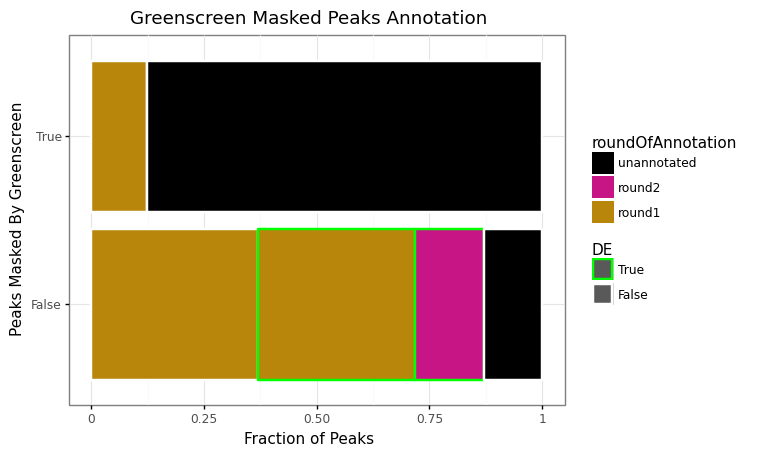

<ggplot: (8786963502532)>

In [40]:
#theme_set(theme_void())
(ggplot(numDEPeaksAnnGivMask_df,
    aes("gs_masked_out", "counts", fill="roundOfAnnotation", colour="DE"))
    + geom_col(size=1, position= "fill")
    + scale_fill_manual(
        values=['k','mediumvioletred','darkgoldenrod'])
    + scale_colour_manual(
        values=['lime','white'])
    + ylab("Fraction of Peaks")
    + xlab("Peaks Masked By Greenscreen")
    + labs(title="Greenscreen Masked Peaks Annotation")
    + coord_flip()
    + theme_bw())


/home/sklasfeld/Desktop/Github/GreenscreenProject/env/lib/python3.8/site-packages/plotnine/guides/guides.py:197: PlotnineWarning: Cannot generate legend for the 'fill' aesthetic. Make sure you have mapped a variable to it


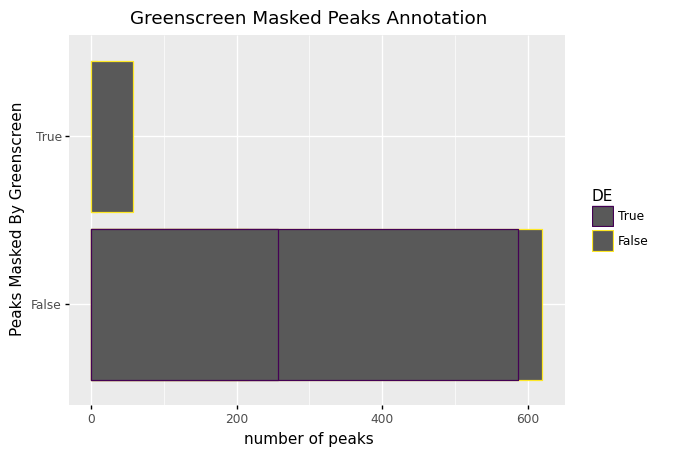

<ggplot: (8786963520250)>

In [41]:

(ggplot(numDEPeaksAnnGivMask_df,
    aes("gs_masked_out", "counts",
       colour="DE"))
    + geom_col(position= "identity")
    + scale_fill_manual(
        values=['k','mediumvioletred','darkgoldenrod'])
    + ylab("number of peaks")
    + xlab("Peaks Masked By Greenscreen")
    + labs(title="Greenscreen Masked Peaks Annotation")
    + coord_flip())

In [42]:
# Annotate to Transposable Elements

Create a counts table of the number of peaks that were: 
* not annotated
* annotated in round 1 annotation
* annotated in round 2 annotation

and whether they were masked out by greenscreen or not.

In [43]:
# create a dataframe of necessary info
numPeaksAnnGivMask_df = (pd.DataFrame(nomask_peakwise_df.groupby(
    'roundOfAnnotation')['gs_masked_out']
    .value_counts())
    .rename(columns={'gs_masked_out':'number of peaks'})
    .reset_index())
# set `gs_masked_out` to str type
numPeaksAnnGivMask_df['gs_masked_out'] = (
    numPeaksAnnGivMask_df['gs_masked_out'].astype(str))
# pivot the table so that the column names
# represent the annotation labels and
# the index labels whether the peaks were
# masked out by the greenscreen (True) 
# or not (False)
numPeaksAnnGivMask_pivot_df = (
    numPeaksAnnGivMask_df.pivot(
    index="gs_masked_out",
    columns="roundOfAnnotation",
    values="number of peaks"))
numPeaksAnnGivMask_pivot_df = numPeaksAnnGivMask_pivot_df.fillna(0)
numPeaksAnnGivMask_pivot_df

roundOfAnnotation,round1,round2,unannotated
gs_masked_out,,,
False,1207.0,257.0,216.0
True,8.0,0.0,57.0


Since so few peaks are masked we calculate the percent for each row in the dataframe.

In [44]:
perPeaksAnnGivMask_pivot_df = numPeaksAnnGivMask_pivot_df.apply(lambda x: x/x.sum(),axis=1)
perPeaksAnnGivMask_pivot_df

roundOfAnnotation,round1,round2,unannotated
gs_masked_out,,,
False,0.718452,0.152976,0.128571
True,0.123077,0.000000,0.876923


Before plotting this table to a stacked bar graph, we prepare the dataframe.

In [45]:
perPeaksAnnGivMask_pivot_V2_df = perPeaksAnnGivMask_pivot_df.loc[['True','False'],:]
perPeaksAnnGivMask_sorted_pivot_df = (
    perPeaksAnnGivMask_pivot_df
    .reset_index()
    .rename_axis(None,axis=1))
perPeaksAnnGivMask_sorted_pivot_df
perPeaksAnnGivMask_sorted_pivot_V2_df = (
    perPeaksAnnGivMask_pivot_V2_df
    .reset_index()
    .rename_axis(None,axis=1))
perPeaksAnnGivMask_sorted_pivot_df

,gs_masked_out,round1,round2,unannotated
0,False,0.718452,0.152976,0.128571
1,True,0.123077,0.000000,0.876923


Use matplotlib libary to plot the stacked bargraph to display the data

Text(0.5, 1.0, 'Greenscreen Masked Peaks Annotation')

<Figure size 1008x1008 with 0 Axes>

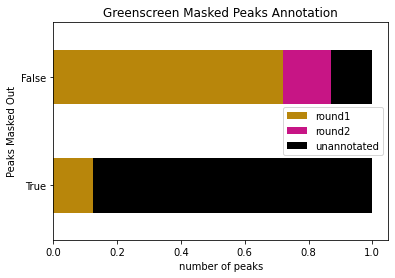

In [46]:
# set the figure size
plt.figure(figsize=(14, 14))

color_dict= (
    {"round1":'o',
    "round2":'b',
    "unannotated":'k'})

# from raw value to percentage
ax = perPeaksAnnGivMask_sorted_pivot_V2_df.plot(
    color=['darkgoldenrod','mediumvioletred','k'],
    x="gs_masked_out",
    kind='barh',
    stacked=True,
    mark_right=True)

ax.set_xlabel("number of peaks")
ax.set_ylabel("Peaks Masked Out")
plt.title("Greenscreen Masked Peaks Annotation")

In [47]:
perPeaksAnnGivMask_sorted_pivot_df

,gs_masked_out,round1,round2,unannotated
0,False,0.718452,0.152976,0.128571
1,True,0.123077,0.000000,0.876923
